In [1]:
# Install needed stuff to the Jupyter and kernel environment
# Need to install only once, so commented out for cleaner output
# %pip install pyarrow
# %pip install pandas
# %pip install numpy
# %pip install matplotlib
# %pip install pyfinance
# %pip install yfinance
# %pip install yahoo-fin

In [2]:
# Import needed stuff
import sys
import pyarrow.feather as feather
import math
import pandas
import numpy as np
import matplotlib.pyplot as plt
from pyfinance.options import BSM
import yfinance as yf
from datetime import datetime, timedelta, date
from yahoo_fin import options as op

In [3]:
# General Delta-hedging function
def number_of_shares_to_buy(shares_per_contract, number_of_options, delta_of_option):
    delta_of_underlying = 1 # why?

    # Delta-hedging says:
    # number_of_shares * delta_of_underlying + number_of_options * delta_of_option = 0
    number_of_shares = (-number_of_options * delta_of_option / delta_of_underlying ) * shares_per_contract

    print("To delta-hedge the portoflio, you need to",("buy" if number_of_shares >= 0 else "sell"), round(np.abs(number_of_shares),2), "shares.")
    return number_of_shares


In [4]:
# General volatility function
def get_volatility(stock_data):
    log_returns = np.log(stock_data/stock_data.shift(1)).dropna()
    volatility = log_returns.rolling(window = 21).std() * np.sqrt(252)
    return volatility
    

In [5]:
# General plot function
def plot_stock_price_and_volatility(stock_prices, volatility):
    fig, ax = plt.subplots()
    ax.plot(stock_prices, color='red')
    ax.set_xlabel('Date', fontsize = 14)
    ax.set_ylabel('Underlying price', color='red', fontsize = 14)
    
    ax2 = ax.twinx()
    ax2.plot(volatility, color = 'blue')
    ax2.set_ylabel('Volatility', color = 'blue', fontsize = 14)
    
    plt.show()
    

## Let's use Apple stock data from Refinitiv here

Delta of the call option: 0.56291693680677
Delta of the put option: -0.43708306319323
To delta-hedge the portoflio, you need to sell 56.29 shares.
To delta-hedge the portoflio, you need to buy 43.71 shares.


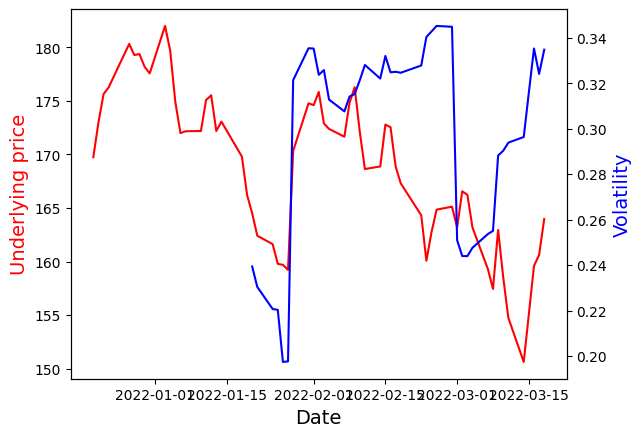

In [6]:
# Read data and show it, data is from Refinitiv workspace
apple_stock_data_as_df = feather.read_feather('../data/fe2.feather')

# Set date to index instead of running index from 1..n
date_as_index = apple_stock_data_as_df.set_index('Date', inplace=False)

vola = get_volatility(date_as_index['Underlying'])

# Set values
shares_per_contract = 100 # How this is determined ?

number_of_options = 1 # How this is determined? 1 stock = 1 option, n stocks = n options?

# Use Black-Scholes model to compute the delta of the call option
# T = maturity and r = interest rate just thrown there, no spesific reason I guess to be those
call_delta = BSM(kind='call', S0=date_as_index['Underlying'].iloc[-1], K=date_as_index['Underlying'].iloc[-1], T=0.25, r=0.05, sigma=vola.iloc[-1]).delta()

# Delta of the call option is always positive and between 0 and 1
print("Delta of the call option:", call_delta)

# Use Black-Scholes model to compute the delta of the put option
# Again T = maturity and r = interest rate are just thrown there, no spesific reason to be those (I think)
put_delta = BSM(kind='put', S0=date_as_index['Underlying'].iloc[-1], K=date_as_index['Underlying'].iloc[-1], T=0.25, r=0.05, sigma=vola.iloc[-1]).delta()

# Delta of the put option is always negative and between 0 and -1
print("Delta of the put option:", put_delta)

# Get the amounts to balance, aka delta-hedge the portfolio
how_many_shares_to_sell = number_of_shares_to_buy(shares_per_contract, number_of_options, call_delta)

how_many_shares_to_buy = number_of_shares_to_buy(shares_per_contract, number_of_options, put_delta)

plot_stock_price_and_volatility(date_as_index['Underlying'], vola)

# Lets try with S&P 500 data

[*********************100%%**********************]  1 of 1 completed


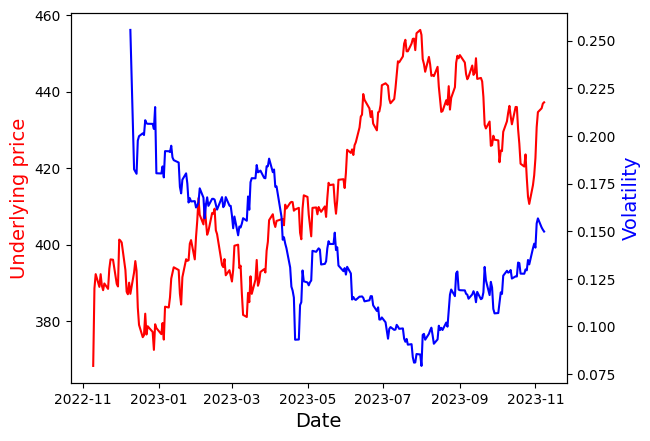

Delta of the call option: 0.580950247408987
Delta of the put option: -0.41904975259101296
To delta-hedge the portoflio, you need to sell 58.1 shares.
To delta-hedge the portoflio, you need to buy 41.9 shares.


In [7]:
stock_name = 'SPY'
years = 1
stock_data = yf.download(tickers = stock_name, start = datetime.today() - timedelta(days=years*365), end = datetime.today())

stock_data # Date as index, Open, High, Low, Close, Adj Close, Volume

stock_prices = stock_data['Adj Close'] # Closing prices
spy_vola = get_volatility(stock_prices)
plot_stock_price_and_volatility(stock_prices, spy_vola)

# Set values
shares_per_contract = 100 # How this is determined ?

number_of_options = 1 # How this is determined? 1 stock = 1 option, n stocks = n options?

# Use Black-Scholes model to compute the delta of the call option
# T = maturity and r = interest rate just thrown there, no spesific reason I guess to be those
call_delta = BSM(kind='call', S0=stock_prices.iloc[-1], K=stock_prices.iloc[-1], T=0.25, r=0.05, sigma=spy_vola.iloc[-1]).delta()

# Delta of the call option is always positive and between 0 and 1
print("Delta of the call option:", call_delta)

# Use Black-Scholes model to compute the delta of the put option
# Again T = maturity and r = interest rate are just thrown there, no spesific reason to be those (I think)
put_delta = BSM(kind='put', S0=stock_prices.iloc[-1], K=stock_prices.iloc[-1], T=0.25, r=0.05, sigma=spy_vola.iloc[-1]).delta()

# Delta of the put option is always negative and between 0 and -1
print("Delta of the put option:", put_delta)

# Get the amounts to balance, aka delta-hedge the portfolio
how_many_shares_to_sell = number_of_shares_to_buy(shares_per_contract, number_of_options, call_delta)

how_many_shares_to_buy = number_of_shares_to_buy(shares_per_contract, number_of_options, put_delta)

## Hedging assigment

In [8]:
 # print(stock_data) # Apple stock data

# Fetch real option data using Yahoo_fin

In [9]:
# Another viable dataset
def fetch_sp500_yahoofin():
    ticker = 'SPY'
    expiration_dates = op.get_expiration_dates(ticker)
    exp = pandas.DataFrame(expiration_dates)
    # print(exp)
    calls = op.get_calls(ticker, date = expiration_dates[13]) # Chose 29.12.2023 
    c = pandas.DataFrame(calls)
    print(c)
    
    long_position_in_call = c.iloc[0]
    print(long_position_in_call)
    print(long_position_in_call['Strike'])
    
    #puts = op.get_puts(ticker, date = expiration_dates[14])
    #print(puts)
    #chain_data = op.get_options_chain(ticker, date=expiration_dates[14])
    #print(chain_data)

# Fetch using yfinance

In [10]:
sp500 = yf.Ticker('SPY')
expiration_dates = pandas.DataFrame(data=sp500.options)
print(expiration_dates)
expiration = expiration_dates.iloc[13][0]
option_chain_for_expiration = sp500.option_chain(expiration) # expiration 29.12.2023
#print(option_chain_for_expiration) # this is both calls and puts

opt_calls = option_chain_for_expiration.calls
print(opt_calls)

# print('============== PUTS ==============')
# opt_puts = option_chain_for_expiration.puts
# print(opt_puts)

             0
0   2023-11-09
1   2023-11-10
2   2023-11-13
3   2023-11-14
4   2023-11-15
5   2023-11-16
6   2023-11-17
7   2023-11-24
8   2023-12-01
9   2023-12-08
10  2023-12-15
11  2023-12-22
12  2023-12-29
13  2024-01-19
14  2024-02-16
15  2024-03-15
16  2024-03-28
17  2024-06-21
18  2024-06-28
19  2024-09-20
20  2024-09-30
21  2024-12-20
22  2025-01-17
23  2025-03-21
24  2025-06-20
25  2025-12-19
26  2026-01-16
         contractSymbol             lastTradeDate  strike  lastPrice     bid  \
0    SPY240119C00180000 2023-10-25 17:42:32+00:00   180.0     238.73    0.00   
1    SPY240119C00185000 2023-05-11 18:08:44+00:00   185.0     229.15  246.96   
2    SPY240119C00190000 2023-09-18 19:39:37+00:00   190.0     255.89  241.82   
3    SPY240119C00195000 2023-09-18 19:39:37+00:00   195.0     251.01  236.88   
4    SPY240119C00200000 2023-11-06 17:35:44+00:00   200.0     235.90    0.00   
..                  ...                       ...     ...        ...     ...   
163  SPY240119C00695

In [41]:
days_to_maturity = datetime(2023, 12, 29) - datetime.today()
t = 49/365
# t = days_to__maturity/365
print(t)
print("Days to maturity in days is", days_to_maturity.days) # 49 days_to_maturity
t0 = datetime(2023, 11, 9).date() # time at t = 0, this takes the first date of the first value of the dataframe
print("Time at t = 0 aka today", t0)
c0 = opt_calls['lastPrice'].iloc[0] # call option with price C0 at time t0
print('Price of Call option c0 in time t0', c0)
r = 0.05
sigma = opt_calls['impliedVolatility'].iloc[0]
val = BSM(kind='call', S0=c0, K=opt_calls['strike'].iloc[0], T=t, r=r, sigma=0.2).value() 
print('value from BSM', val)
print('Delta from BSM', BSM(kind='call', S0=c0, K=opt_calls['strike'].iloc[0], T=t, r=r, sigma=0.2).delta() )

# Construct two portfolios
# op = long position in one call, op0 = c0
# re = short position containing delta amount of the underlying asset S, re0 = delta0 * s0 (stock price at 0)
# Changes in the protfolio OP are neutralized by oppsite changes in the replicatin portfolio re
# rehedge every second day
# Compute how much every portfolio has changed
# Count mean squared error

0.13424657534246576
Days to maturity in days is 49
Time at t = 0 aka today 2023-11-09
Price of Call option c0 in time t0 238.73
value from BSM 59.934311005301765
Delta from BSM 0.9999657825043815
